<a href="https://colab.research.google.com/github/ivangoldov/sirius/blob/main/Sirius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашняя работа по современным сверточным нейросетям
**Kaggle: [competition](https://www.kaggle.com/c/sirius-spbsu-2022-entry-competition), [invite link](https://www.kaggle.com/t/d4064bcb01564f05bc5c0da9d141cd7c)**

**Kaggle deadline: 13.02.2022 23:59:00 +0000 GMT**

### Описание

В этой домашней работе нужно написать сверточную нейронную сеть для классификации изображений.

Вам предоставлен измененный датасет The Street View House Numbers ([SVHN](http://ufldl.stanford.edu/housenumbers/)). В нём содержится 50 тысяч (train) + 25 тысяч (test) RGB изображений размера 32х32 c цифрами, вырезанными из реальных фотографий номеров домов.

Задача: используя свёрточные нейронные сети, добиться максимальной точности классификации.

В данном домашнем задании нет никаких ограничений по архитектуре модели, но реализовывать в PyTorch её надо самим и обучить с нуля только на данном датасете, без внешних данных.

### Данные

В данном ноутбуке уже есть код для PyTorch, отвечающий за загрузку данных. Ниже приведено краткое описание формата хранения данных.

Каждый из файлов — сериализованный с помощью `pickle` c 4-ой версией протокола (которая стала версией по умолчанию в Python 3.8 и старше) python-словарик.

Список файлов:

- `meta` — метаданные датасета (например, названия классов)
- `data_train` — данные для обучения, 50К объектов
- `data_test` — данные для теста, 25К объектов, без правильных классов

Словарики с данными имеют следующие поля:

- `section` — имя части данных (train/test)
- `labels` — ground-truth классы, список из `N` чисел от 0 до 9
- `images` — numpy-массив размером `(N, 32, 32, 3)` с изображениями

### Оценка

Качество решения будет оцениваться по метрике accuracy (точность). Accuracy – это количество правильно классифицированных картинок к общему числу картинок в тестовом наборе. Публичный лидерборд рассчитывается по 30% тестовых данных, поэтому старайтесь не переобучаться под него.

```
accuracy = (correct classified) / (total # of examples)
```

В качестве решения вы должны прислать файл формата:

```
Id,Category
0, 3
1, 2
2, 9
3, 1
...
```

где:

- `Id` — порядковый номер объекта в тестовом датасете
- `Category` — предсказанный класс объекта

В данном ноутбуке уже есть код, подготавливающий файл решения.

### Эксперименты

Так как в обучении нейросетевой модели есть очень много различных гиперпараметров, в данном задании нужно будет делать много различных экспериментов. И будет очень полезно, и для вас самих, и для нас, проверяющих, наличие текстового описания всех, или по крайней мере самых интересных/важных в выборе итоговой модели, экспериментов с результатами в финальном ноутбуке. Наличие и подробность описания экспериментов будут входить в итоговую оценку за домашнее задание. Дедлайн на Kaggle специально поставлен немного раньше, чтобы у вас было время спокойно дописать отчет об экспериментах.

In [1]:
!pip -qq install matplotlib gdown 

In [2]:
!apt-get install -y -qq unzip

debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 9772 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-21ubuntu1.1) ...
Setting up unzip (6.0-21ubuntu1.1) ...


## Решение

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [4]:
import os
import pickle
from typing import Any, Callable, Optional, Tuple, List
from PIL import Image

In [42]:
import torch
import torchvision
import torch.nn.functional as F
from torch.nn.modules.pooling import MaxPool2d
from torch import nn, Tensor
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import (ToTensor, Compose, RandomRotation, ColorJitter, RandomPosterize, 
                                    RandomInvert, AutoAugmentPolicy, AutoAugment)
from torchvision.datasets.vision import VisionDataset
from torch.utils.data.sampler import WeightedRandomSampler

In [6]:
!gdown --id 1XI3mE_hzVxtckT4f0RTF9l4wUJ6bgeWu -O data.zip -q

In [7]:
!unzip data.zip

Archive:  data.zip
  inflating: data_test               
  inflating: data_train              
  inflating: meta                    


Данные лежат в секции [Data](https://www.kaggle.com/c/sirius-spbsu-2022-entry-competition/data) kaggle-соревнования. <br>
Нужно скачать архив с данными и распаковать его. <br>
В переменной ниже указываем путь до датасета. <br>

In [8]:
dataset_root = '.'

Код для загрузки измененного датасета SVHN. Аргументы инициализации:

- `root` — строка, путь до директории с файлами датасета
- `is_train` — флаг, загружать часть для обучения или теста
- `transform` — преобразования изображения
- `target_transform` — преобразования класса изображения

In [9]:
class SVHN(VisionDataset):

    def __init__(self,
                 root: str,
                 is_train: bool = True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)
        self.is_train = is_train

        meta_path = os.path.join(self.root, 'meta')
        with open(meta_path, "rb") as f:
            content = pickle.load(f)
            self.classes = content['label_names']
            self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        data_path = os.path.join(self.root, 'data_train' if is_train else 'data_test')
        with open(data_path, "rb") as f:
            content = pickle.load(f)
            self.data = content['images']
            self.targets = content.get('labels')

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.fromarray(self.data[index].astype(np.uint8))
        target = self.targets[index] if self.is_train else len(self.classes)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)
        
    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

### Загрузка датасета

Загружаем часть датасета для обучения.

In [10]:
data = SVHN(
    root=dataset_root,
    is_train=True,
    transform=ToTensor(),
)

Разбиваем случайным образом датасет на обучение и валидацию. <br>
На первой части будем обучать модель классификации. <br>
На второй части будем оценивать качество во время экспериментов. <br>

In [11]:
train_data, val_data = torch.utils.data.random_split(
    data, 
    [40000, 10000], 
    generator=torch.Generator().manual_seed(137),
)

Инициализируем data loader-ы.

In [12]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

Посмотрим, какой размерности батчи выдает data loader.

In [13]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32])
Shape of y:  torch.Size([64]) torch.uint8


### Модель классификации

Определяем, на каком устройстве будем обучать модель.

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Задаем архитектуру модели классификации. <br>
Тут большой простор для разных экспериментов. <br>

In [15]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 10),
)

Отправляем модель на выбранное устройство.

In [16]:
model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=10, bias=True)
)


### Обучение

Задаем функцию потерь (цель оптимизации) и оптимизатор.

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Код для визуализации процесса обучения.

Каждые `interval` шагов оптимизации и в конце эпох мы записываем значения функции потерь и метрик в лог. <br>
Затем вызовом функции `show_progress` обновляем график обучения. <br>

In [18]:
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [19]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 

In [20]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [21]:
def test(epoch, dataloader, model, loss_fn, max_acc, best_model) -> Tuple[float, nn.Module]:
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)
    if correct > max_acc:
        best_model = model
        max_acc = correct
    return max_acc, best_model

Цикл обучения.

In [22]:
def train_model(model, 
                optimizer, 
                train_loader,
                val_loader,
                filename: str = 'solution.csv',
                loss_fn: Callable = nn.CrossEntropyLoss(), 
                epochs: int = 50) -> Tuple[float, nn.Module]:
    max_acc = -1.
    best_model = None
    for t in trange(epochs):
        train(t, train_loader, model, loss_fn, optimizer)
        max_acc, best_model = test(t, val_loader, model, loss_fn, max_acc, best_model)
        write_solution(filename, best_model)
    return max_acc, best_model

In [23]:
# train_model(model, optimizer)

### Отправка решения

Загружаем часть датасета для теста.

In [24]:
test_data = SVHN(
    root=dataset_root,
    is_train=False,
    transform=ToTensor(),
)

In [25]:
test_dataloader = DataLoader(
    test_data, 
    batch_size=batch_size,
)

Делаем предсказания итоговой моделью.

In [26]:
def predict(model: nn.Module) -> List[int]:

    predictions = []

    model.eval()
    with torch.no_grad():
        for X, _ in test_dataloader:
            X = X.to(device)
            pred = model(X).argmax(1).cpu().numpy()
            predictions.extend(list(pred))
    return predictions

Формируем файл решения для отправки в kaggle.

In [27]:
def write_solution(filename: str, model: nn.Module):
    labels = predict(model)
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


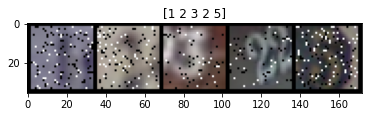

In [28]:
# посмотрим на сами картинки
def show_image(tensor: torch.Tensor, title=None):
    tensor = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0., 0., 0.])
    std = np.array([1., 1., 1.])
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    plt.imshow(tensor)
    if title is not None:
        plt.title(title)
        
def show_images(data):
    for img, label in DataLoader(data, batch_size=5, shuffle=True):
        out = torchvision.utils.make_grid(img)
        show_image(out, label.numpy())
        break


show_images(train_data)

In [29]:
# простая сверточная сеть

class ConvNet(nn.Module):
    def __init__(self,
                 n_classes: int = 10, 
                 in_channels: int = 3,
                 kernel_size: int = 3,
                 conv_layers: int = 3,
                 padding: int = 1,
                 padding_mode = 'reflect'):
        super().__init__()
        out_c = 16
        convs = [nn.Conv2d(in_channels, out_c, kernel_size)]
        for _ in range(conv_layers):
            convs += [nn.Conv2d(out_c, out_c * 2, kernel_size),
                      nn.MaxPool2d(2),
                      nn.ReLU()]
            out_c *= 2
        self.convs = nn.Sequential(*convs)
        self.bottleneck1 = nn.Conv2d(out_c, out_c, kernel_size, padding=padding, padding_mode=padding_mode)
        self.linear = nn.Linear(512, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convs:
            x = F.relu(conv(x))
        x = F.relu(self.bottleneck1(x))
        return self.linear(x.flatten(1))


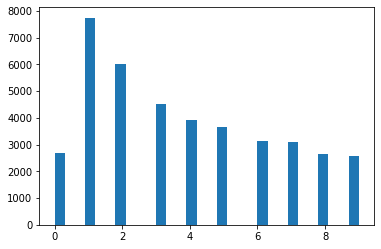

In [30]:
# распределение лейблов в трейне
plt.hist([i for _, i in train_data], bins=30);

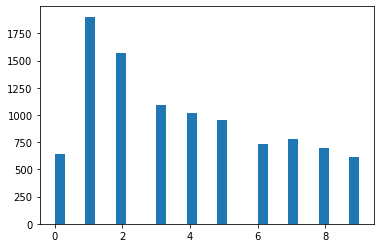

In [31]:
# распределение лейблов в валидационном сете
plt.hist([i for _, i in val_data], bins=30);

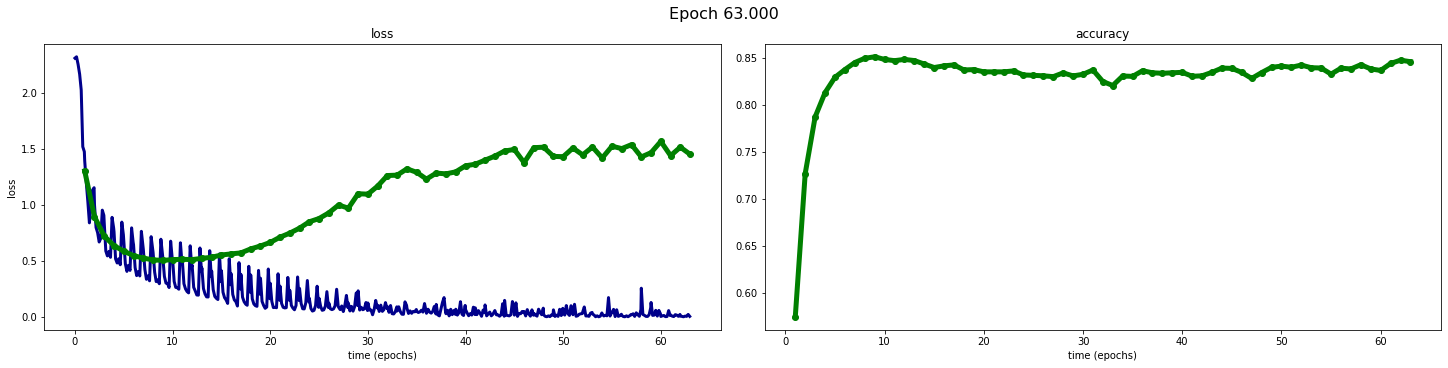

0.8511


 62% 62/100 [20:12<12:23, 19.56s/it]


KeyboardInterrupt: 

In [43]:
train_ts, train_loss, val_ts, val_loss, val_acc = [], [], [], [], []

convnet = ConvNet()
convnet.to(device)
optimizer = torch.optim.AdamW(convnet.parameters(), lr=3e-4)
train_model(convnet, optimizer, train_dataloader, val_dataloader, epochs=100);

Как видно, accuracy < 0.9 и быстро наступает переобучение, то есть модель не может пофититься на настоящее распределение, поэтому воспользуемся более сложными моделями, вариациями ResNet

In [32]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: Tensor) -> Tensor:
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks: List[int], n_classes: int = 10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, num_blocks[0], 1)
        self.layer2 = self._make_layer(128, num_blocks[1], 2)
        self.layer3 = self._make_layer(256, num_blocks[2], 2)
        self.layer4 = self._make_layer(512, num_blocks[3], 2)
        self.linear = nn.Linear(512, n_classes)

    def _make_layer(self, channels: int, n_blocks: int, stride: int):
        strides = [stride] + [1] * (n_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, channels, stride))
            self.in_planes = channels
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    
def ResNetSmall():
    return ResNet([1, 1, 1, 1])


def ResNet18():
    return ResNet([2, 2, 2, 2])


def ResNet34():
    return ResNet([3, 4, 6, 3])

In [40]:
# тест "маленького" resnet

train_ts, train_loss, val_ts, val_loss, val_acc  = [], [], [], [], []

resnet_small = ResNetSmall()
resnet_small.to(device)
optimizer = torch.optim.AdamW(resnet_small.parameters(), lr=3e-4, weight_decay=0.1)
accuracy, best_model = train_model(resnet_small, optimizer, train_dataloader, val_dataloader, epochs=200, filename='small_resnet.csv')

 38% 77/200 [35:07<56:05, 27.37s/it]


KeyboardInterrupt: 

In [62]:
# попробуем добавить аугментаций и отбалансировать классы
# не удалось зафиксировать абсолютно все эксперименты в коде из-за проблем с колабом, некоторые версии стерлись при крашах

# итоги такие, что ResNetSmall не обладает нужной аппроксимационной способностью, ResNet18 и ResNet34 показывали себя примерно
# одинаково, поэтому в основном происходил тюнинг этих моделей, тюнинг lr, сравнение Adam и AdamW
# Наивысший accuracy на паблике показала ResNet34, AdamW с 1e-3 lr, 90 эпох и последней версией аугментаций

train_transforms_0 = Compose([  # были протестированы все эти три аугментации
     ColorJitter(brightness=0.5, hue=0.3),
     RandomPosterize(bits=2),
     ToTensor()
])

train_transforms_1 = Compose([
     ColorJitter(brightness=0.5, hue=0.5),
     RandomInvert(),
     RandomPosterize(bits=8),
     ToTensor()
])

train_transforms = Compose([  # с этой аугментацией получился наилучший результат.
    AutoAugment(AutoAugmentPolicy.SVHN),
    ToTensor()
])

data = SVHN(
    root=dataset_root,
    is_train=True,
    transform=train_transforms,
)

train_data_aug, val_data_aug = torch.utils.data.random_split(
    data, 
    [49000, 1000], 
    generator=torch.Generator().manual_seed(0),
)

In [56]:
labels = [label for img, label in train_data_aug]

In [57]:
class_counts = [0 for _ in range(10)]
for label in labels:
    class_counts[label] += 1
class_counts

[3288, 9470, 7449, 5514, 4836, 4507, 3784, 3796, 3247, 3109]

In [58]:
# пользуемся дисбалансом посредством добавления весов

num_samples = sum(class_counts)
class_weights = np.array([num_samples / class_count for class_count in class_counts])
class_weights /= np.sqrt(np.sum(class_weights**2))
weights = [class_weights[labels[i]] for i in range(num_samples)]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), num_samples)
train_loader_aug = DataLoader(train_data_aug, sampler=sampler, batch_size=batch_size)
val_loader_aug = DataLoader(val_data_aug, batch_size=batch_size)
class_weights

array([0.39794862, 0.13816843, 0.17565513, 0.23729689, 0.27056556,
       0.29031619, 0.34578622, 0.34469312, 0.40297353, 0.42086043])

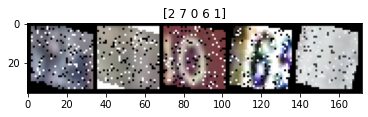

In [59]:
# посмотрим, какими получились аугментации

show_images(train_data_aug)

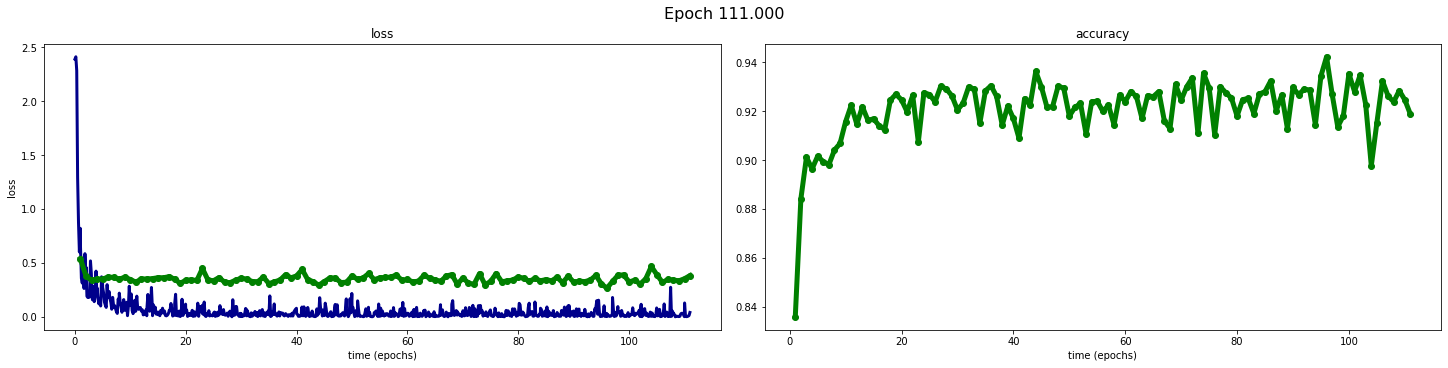

 55% 110/200 [2:13:10<1:48:57, 72.64s/it]


KeyboardInterrupt: 

In [60]:
# попробуем разные lr, 1e-3, 1e-4, 3e-4 и разные вариации ResNet
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

resnet_aug = ResNet34()
resnet_aug.to(device)
optimizer = torch.optim.AdamW(resnet_aug.parameters(), lr=1e-3, weight_decay=0.1)   
accuracy, best_resnet_aug = train_model(resnet_aug, 
                                        optimizer, 
                                        train_loader_aug, 
                                        val_loader_aug, epochs=200, filename='resnet34_svhn_aug.csv')

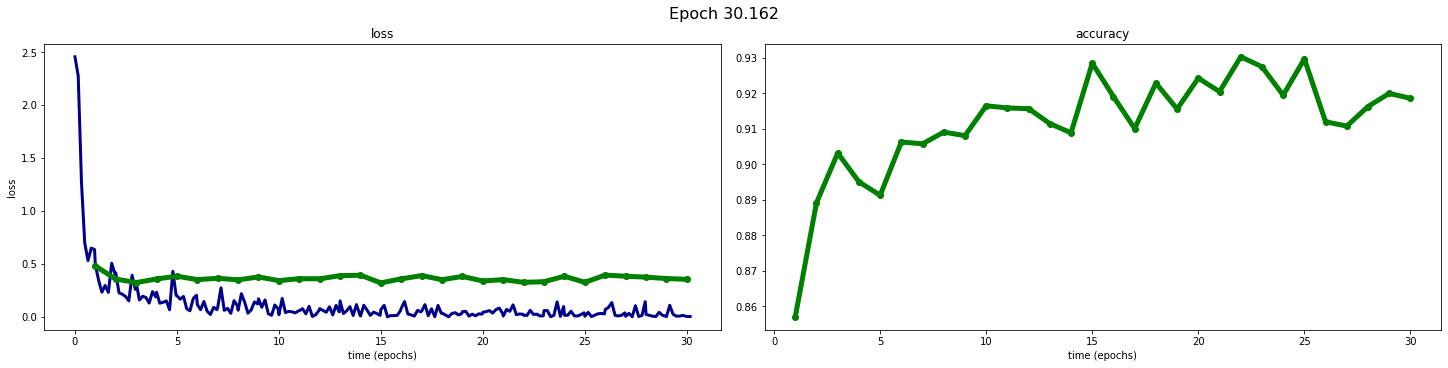

 15% 30/200 [25:18<2:23:25, 50.62s/it]


KeyboardInterrupt: 

In [61]:
# попробуем разные lr, 1e-3, 1e-4, 3e-4
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

resnet_aug = ResNet18()
resnet_aug.to(device)
optimizer = torch.optim.AdamW(resnet_aug.parameters(), lr=1e-3, weight_decay=0.1)   
accuracy, best_resnet_aug = train_model(resnet_aug, 
                                        optimizer, 
                                        train_loader_aug, 
                                        val_loader_aug, 
                                        filename='resnet18_svhn_aug.csv', 
                                        epochs=200)